In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/pytorch-yolov5/

/content/gdrive/My Drive/pytorch-yolov5


In [3]:
!tar -xzvf "cudnn-10.0-linux-x64-v7.6.5.32.tgz" -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


#### Yolov5 Kurulumu

In [4]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


Hazır modelleri kullanarak yolov5 tespit sonuçlarını gör.



Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5x.pt'])
YOLOv5 🚀 2021-4-11 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 476 layers, 87730285 parameters, 0 gradients, 218.8 GFLOPS
image 1/1 /content/gdrive/My Drive/pytorch-yolov5/yolov5/data/images/teknofest.jpg: 480x640 7 persons, 2 bottles, 1 cup, 6 chairs, 4 dining tables, Done. (0.040s)
Results saved to runs/detect/exp5
Done. (0.104s)


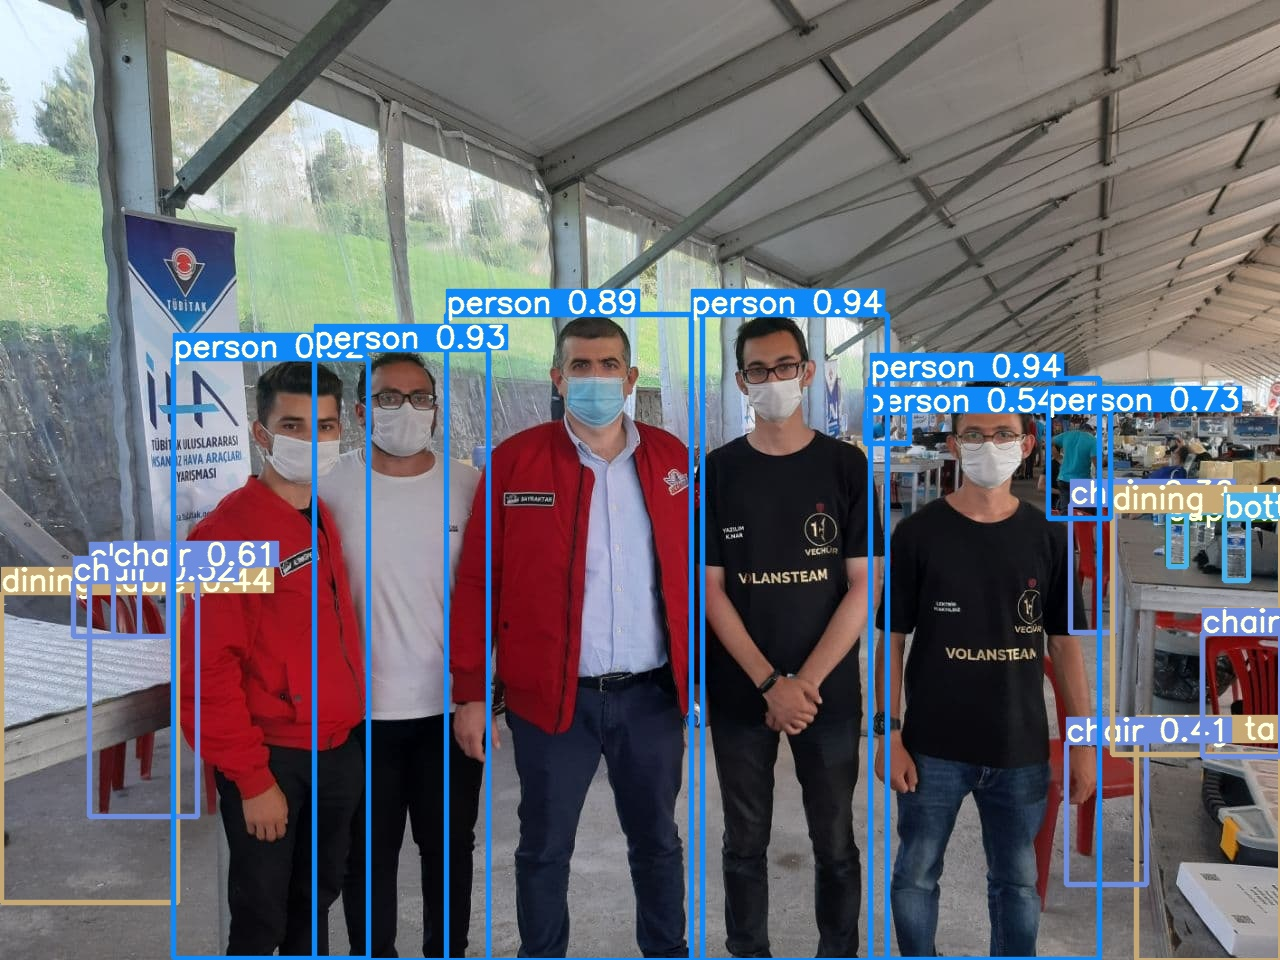

In [25]:
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp5/teknofest.jpg', width=600)

Coco veri seti indirme işlemleri

In [ ]:
# Download COCO val2017
torch.hub.download_url_to_file('https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017val.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [ ]:
# Run YOLOv5x on COCO val2017
!python test.py --weights yolov5x.pt --data coco.yaml --img 640 --iou 0.65

Yolov5 ile Eğitim

In [ ]:
# Download COCO test-dev2017
torch.hub.download_url_to_file('https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip # unzip labels
!f="test2017.zip" && curl http://images.cocodataset.org/zips/$f -o $f && unzip -q $f && rm $f  # 7GB,  41k images
%mv ./test2017 ../coco/images  # move to /coco

In [ ]:
# Run YOLOv5s on COCO test-dev2017 using --task test
!python test.py --weights yolov5s.pt --data coco.yaml --task test

In [ ]:
# Tensorboard (optional)
%load_ext tensorboard
%tensorboard --logdir runs/train

In [ ]:
# Weights & Biases (optional)
%pip install -q wandb  
!wandb login  # use 'wandb disabled' or 'wandb enabled' to disable or enable

In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache

Görselleştirme

In [ ]:
Image(filename='runs/train/exp/train_batch0.jpg', width=800)  # train batch 0 mosaics and labels
Image(filename='runs/train/exp/test_batch0_labels.jpg', width=800)  # test batch 0 labels
Image(filename='runs/train/exp/test_batch0_pred.jpg', width=800)  # test batch 0 predictions

In [ ]:
from utils.plots import plot_results 
plot_results(save_dir='runs/train/exp')  # plot all results*.txt as results.png
Image(filename='runs/train/exp/results.png', width=800)

Bitti

In [ ]:
# Profile
from utils.torch_utils import profile 

m1 = lambda x: x * torch.sigmoid(x)
m2 = torch.nn.SiLU()
profile(x=torch.randn(16, 3, 640, 640), ops=[m1, m2], n=100)